# HW1: Frame-Level Speech Recognition

In [ ]:
# HW1P2 Code and Ablation Log Submission

## Overview
This notebook contains the code and documentation for HW1P2.
## Files Included

## Instructions to Run the Code
1. Install Dependencies
   Ensure you have the required Python packages installed:
   pip install torch torchvision tqdm wandb

2. Run the Notebook

   ### Locally
   Open and run `vishakha_submission.ipynb` in a Jupyter Notebook environment:

   - jupyter notebook vishakha_submission.ipynb

   or execute the notebook in a Python script using:

   - jupyter nbconvert --to script vishakha_submission.ipynb
   python vishakha_submission.py

   ### Running in Google Colab
   - Upload `vishakha_submission.ipynb` to Google Drive.
   - Open Google Colab and click File → Open Notebook.
   - Open the uploaded notebook.
   - If GPU acceleration is needed, navigate to Runtime → Change runtime type and select GPU.
   - Run all cells in sequence.



## Model Details
- Architecture: Deep fully connected neural network.
- Number of Layers: 11.
- Activation Function: GELU.
- Regularization: Batch Normalization, Dropout (0.25).
- Loss Function: Cross-Entropy Loss.
- Optimizer: AdamW.
- Scheduler: CosineAnnealingLR with `scheduler_mode = min`.
- Weight Initialization: Kaiming Normal.
- Training Epochs(Planned): 45
- Training Epochs(Completed): 38
- Batch Size: 1024.
- Learning Rate: 0.0005.
- Weight Decay: 1e-4.
- Data Augmentations: Both Frequency Masking and Time Masking (`freq_mask_param = 4`, `time_mask_param = 8`).
- Learning Rate Reduction:
  - Factor: `0.1`
  - Patience: `5 epochs`
  - Minimum LR: `1e-9`

##  Results
- Final Learning Rate: `4e-05`
- Training Accuracy: `84.97%`
- Training Loss: `0.44405`
- Validation Accuracy: `86.66%`
- Validation Loss: `0.39196`

## Experiments and Ablations
The following hyperparameter tuning experiments were conducted:
- Learning Rate Variations: Tested {0.001, 0.0005, 0.0001}.
- Batch Sizes: Compared {1024, 512, 2048}.
- Layer Depth Adjustments: Different network depths were tested.

For more details, refer to:
- WandB Project Link: https://wandb.ai/vmpathak-carnegie-mellon-university/hw1p2?nw=nwuservmpathak
- Ablations Sheet: Included in the handin.tar file


Author: Vishakha Pathak


In this homework, you will be working with MFCC data consisting of 28 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Dataset Description

Let's start by understanding the dataset for this homework.

Our data consists of 3 folders (train-clean-100, dev-clean and test-clean). The training and validation datasets (train-clean-100 and dev-clean) each contain 2 subfolders (mfcc and transcript). The 'mfcc' subfolder contains mel spectrograms (explained below and in writeup), while the 'transcript' subfolder contains their corresponding transcripts. However, the test dataset (test-clean) contains only the 'mfcc' subfolder without the corresponding transcripts, which will later be predicted by your model.


## 1. Audio Representation.
The 'mfcc' subfolders contain many `*.npy` files of mel spectrograms. .npy files are used to store numpy arrays.

Each .npy file represents a short speech recording. For example, one recording might be someone saying, "This is the age of AI." This recording is converted into a mel spectrogram, which is used to represent all forms of audio signals in a computer. Such representation is important in signal and speech processing tasks, especially in machine learning.

Compared to raw audio, mel spectrograms are better for speech processing because they capture both the timing and the frequencies of the sound. At each moment in time, they show which frequencies are present in the sound. This makes it easier for computers to understand and process speech.

When converting raw audio to spectrograms, you do not process the whole audio at once. Instead, you process small frames at a time as you stride over the entire audio length. This means that if you have an audio file of 100 seconds, you may decide to process 10 seconds at a time, striding by one second. In this case, the frame size is 10 seconds. The frame size and the number of timesteps (seconds, milliseconds, etc.) depend on individual choice.

When processing each frame, you extract a number of features that represent that frame's audio. For instance, in the audio recording of "This is the age of AI," the frame corresponding to "AI" will have features that represent how "AI" is pronounced, the vocal tract, and the effect of the environment in which it was recorded. For clarity, when we say features, you should think of columns. One feature/column may have information about the gender of the person who made the speech. Another may have information about the age of the person. Another may have information about the environment where the speech was recorded. Basically, the main properties that make up a speech are encoded in those features, which combine in some way to make the audio.

Since we want to recognize the word as it was pronounced despite the environment and other variabilities, we usually normalize to eliminate or minimize such effects.

Our spectrograms contain 28 features. Essentially, the number of features may be different. They may depend on how the raw audio data was converted into mel spectrograms.

## 2. Transcripts
Remember where we mentioned frames? Well, in our dataset, audio frames have corresponding target transcripts. For instance the abbreviation "AI", in our example above, if present in the recordings, will have transcripts: /eɪ aɪ/. This means that you will have two frames one for  /eɪ/ and another for /aɪ/.

This way of representing pronounciation in text form is called ***phonetic transcription***, "the conversion of spoken words the way they are pronounced instead of how they are written"[[link]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://krisp.ai/blog/phonetic-transcription/%23:~:text%3Dphonetic%2520transcriptions%2520done.-,What%2520are%2520Phonetic%2520Transcriptions%253F,verbatim%2520to%2520intelligent%2520verbatim%2520transcriptions.&ved=2ahUKEwiV6LO6hrSHAxUKSvEDHcvwAAsQFnoECB0QAw&usg=AOvVaw0VqoWceOzdVwe-AvdyyWqJ). In this case letters 'A' and 'I' are pronounce /eɪ/ and /aɪ/, respectively. Both letters in different words may be pronounced differently.

The produced representation of the speech is referred to as phonemes. Various .npy files that contain recordings of the sentence **"This is the age of AI."** would map to **"/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/."** The phonemes representation for **Chelsea sucks** would be **/ˈtʃɛl.si sʌks/**

Going inside the .npy files. Each .npy file contains vectors which have 28 features/dimensions/columns. The number of vectors in the file corresponds to the number of frames in the recording. And each single frame has a corresponding phoneme in the transcript.

For instance the .npy file for "This is the age of AI" --> "/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/" might have 13 frames (13 vectors):

- /ðɪs/ has 3 phonemes: /ð/, /ɪ/, /s/  
- /ɪz/ has 2 phonemes: /ɪ/, /z/
- /ðə/ has 2 phonemes: /ð/, /ə/
- /eɪdʒ/ has 2 phonemes: /eɪ/, /dʒ/
- /əv/ has 2 phonemes: /ə/, /v/
- /eɪ aɪ/ has 2 phonemes: /eɪ/, /aɪ/

**Chelsea sucks** --> **/ˈtʃɛl.si sʌks/** might have 8 frames (8 vectors):

- /ˈtʃɛl.si/ has 4 phonemes: /tʃ/, /ɛ/, /l/, /si/
- /sʌks/ has 4 phonemes: /s/, /ʌ/, /k/, /s/

Note that recordings of different sentences may have different number of frames.

The model you will produce must take a vector of a particular frame and predict the frame's transcript as accurately as possible.

Therefore, the **__getitem__** method of your dataset class must return a 28 dimensional vector of a particular frame and its corresponding phoneme transcript.

This means that, while you are doing your data preprocessing in the **__init__** method, you need stack all vectors from all recordings on top of each other. You must do this for all transcripts as well and remember to ensure the correspondance between frames and their phoneme mapping is maintained.

For our dataset of two samples above, if you stack the recordings together, you get:


| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme |
|-------|-----------|-----------|-----|------------|---------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     |
| 16    | v16_1     | v16_2     | ... | v16_28     | /si/     |
| 17    | v17_1     | v17_2     | ... | v17_28     | /s/     |
| 18    | v18_1     | v18_2     | ... | v18_28     | /ʌ/     |
| 19    | v19_1     | v19_2     | ... | v19_28     | /k/     |
| 20    | v20_1     | v20_2     | ... | v20_28     | /s/     |


So, if you pass index 5 to **__getitem__**, you will get back vector v5 (v5_1, v5_2, ..., v5_28) and transcript **/ð/**. Ideally, if you have a well trained model, it should take v5 and return **/ð/**. And the call to **__len__** would return 21 which the training loop would use to go through the whole dataset.

## Context

In the dataset we are using, a few millisecs were used to convert raw audio to mel spectrogram and extract the 28 features.
Since each vector represents only a few millisecs of speech, it may not be sufficient to feed only a single vector into the network at a time. Instead, it may be useful to provide the network with some “context” of size K around each vector in terms of additional vectors from the speech input.

Concretely, a context of size 3 would mean that we provide an input of size (7, 28) to the network - the size 7 can be explained as: the vector to predict the label for, 3 vectors preceding this vector, and 3 vectors following it. It is worth thinking about how you would handle providing context before one of the first K frames of an utterance or after one of the last K frames.

There are several ways to implement this, but you could try the simplest one:
- Concatenating all utterances and padding with K 0-valued vectors before and after the resulting matrix

If you use a context of 3 on the above table, you get the following table:

| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme | Context Vectors |
|-------|-----------|-----------|-----|------------|---------|----------------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3 |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4 |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     | [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4, v5 |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     | v0, v1, v2, v3, v4, v5, v6 |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     | v1, v2, v3, v4, v5, v6, v7 |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     | v2, v3, v4, v5, v6, v7, v8 |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     | v3, v4, v5, v6, v7, v8, v9 |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    | v4, v5, v6, v7, v8, v9, v10 |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    | v5, v6, v7, v8, v9, v10, v11 |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     | v6, v7, v8, v9, v10, v11, v12 |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     | v7, v8, v9, v10, v11, v12, v13 |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    | v8, v9, v10, v11, v12, v13, v14 |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    | v9, v10, v11, v12, v13, v14, v15 |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    | v10, v11, v12, v13, v14, v15, v16 |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     | v11, v12, v13, v14, v15, v16, v17 |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     | v12, v13, v14, v15, v16, v17, v18 |
| 16    | v16_1     | v16_2     | ... | v16_28     | /s/     | v13, v14, v15, v16, v17, v18, v19 |
| 17    | v17_1     | v17_2     | ... | v17_28     | /i/     | v14, v15, v16, v17, v18, v19, v20 |
| 18    | v18_1     | v18_2     | ... | v18_28     | /s/     | v15, v16, v17, v18, v19, v20, v21 |
| 19    | v19_1     | v19_2     | ... | v19_28     | /ʌ/     | v16, v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding) |
| 20    | v20_1     | v20_2     | ... | v20_28     | /k/     | v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |
| 21    | v21_1     | v21_2     | ... | v21_28     | /s/     | v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |


Now, if you want to predict the output of vector v5, you won't just pass vector v5 alone. You will concatenate 3 vectors before it and 3 vectors after, which makes it 7 vectors ([v2, v3, v4, v5, v6, v7, v8 ]) . This needs to be reflected in your **__getitem__** method. Meaning it should return an array of shape (7, 28), in this example.

Hence your model is going to be taking a tensor (array) of shape (7, 28) in this example.

# Libraries

In [ ]:
!pip install torchsummary


In [ ]:
!pip install torchaudio --quiet

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchsummary import summary
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torchaudio
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)



Device:  cuda


# Mount Google Drive

In [ ]:
''' If you are using colab, you can import google drive to save model checkpoints in a folder
    If you want to use it, uncomment the two lines below
'''
#from google.colab import drive
#drive.mount('/content/drive')

' If you are using colab, you can import google drive to save model checkpoints in a folder\n    If you want to use it, uncomment the two lines below\n'

In [ ]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [ ]:
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"vishakhapathak18","key":"5f212c500556779279ca065e3bedca10"}')

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# commands to download data from kaggle
!kaggle competitions download -c 11785-spring-25-hw-1-p-2

# Unzip downloaded data
!unzip -qo /content/11785-spring-25-hw-1-p-2.zip -d '/content'

11785-spring-25-hw-1-p-2.zip: Skipping, found more recently modified local copy (use --force to force download)


# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [ ]:
config = {
    'Name': 'Vishakha Pathak', # Write your name here
    'subset': 1.0, # Subset of dataset to use (1.0 == 100% of data)
    'context': 25,
    'archetype': 'cylinder',  # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'GELU',
    'learning_rate': 0.0005,
    'dropout': 0.25,
    'optimizers': 'AdamW',
    'scheduler': 'CosineAnnealingLR',
    'scheduler_mode' : 'min',
    'epochs': 45,
    'batch_size': 1024,
    'weight_decay': 1e-4,
    'weight_initialization': 'kaiming_normal', # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8,
    'lr_factor'      : 0.1,    # Factor to reduce the learning rate
    'lr_patience'    : 5,      # Number of epochs with no improvement after which learning rate will be reduced
    'min_lr'         : 1e-9,     # Minimum learning rate
 }

In [ ]:
config

{'Name': 'Vishakha Pathak',
 'subset': 1.0,
 'context': 25,
 'archetype': 'cylinder',
 'activations': 'GELU',
 'learning_rate': 0.0005,
 'dropout': 0.25,
 'optimizers': 'AdamW',
 'scheduler': 'CosineAnnealingLR',
 'scheduler_mode': 'min',
 'epochs': 45,
 'batch_size': 1024,
 'weight_decay': 0.0001,
 'weight_initialization': 'kaiming_normal',
 'augmentations': 'Both',
 'freq_mask_param': 4,
 'time_mask_param': 8,
 'lr_factor': 0.1,
 'lr_patience': 5,
 'min_lr': 1e-09}

# Dataset Class

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [ ]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100", max_samples=None): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes
        self.subset = config['subset']

        # TODO: Initialize augmentations. Read the Pytorch torchaudio documentations on timemasking and frequencymasking
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=4)
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=8)


        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir = os.path.join(root, partition, "mfcc")

        # TODO: Transcripts directory - use partition to acces train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root, partition, "transcript")

        # TODO: List files in sefl.mfcc_dir using os.listdir in SORTED order
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))
        # TODO: List files in self.transcript_dir using os.listdir in SORTED order
        transcript_names    = sorted(os.listdir(self.transcript_dir))

        assert len(mfcc_names) == len(transcript_names)

        # Compute size of data subset
        subset_size = int(self.subset * len(mfcc_names))

        # Select subset of data to use
        if max_samples is not None:
            mfcc_names = mfcc_names[:max_samples]
            transcript_names = transcript_names[:max_samples]

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_names[i])
            mfcc = np.load(mfcc_path)

            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfcc, dtype=torch.float32)

            # TODO: Load the corresponding transcript
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript_path = os.path.join(self.transcript_dir, transcript_names[i])
            transcript = np.load(transcript_path)

            transcript = transcript[1:-1]

            # The available phonemes in the transcript are of string data type
            # But the neural network cannot predict strings as such.
            # Hence, we map these phonemes to integers

            # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
            transcript_indices = [self.phonemes.index(p) for p in transcript]

            # Now, if an element in the transcript is 0, it means that it is 'SIL' (as per the above example)

            # Convert transcript to tensor
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)

        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...
        # Each transcript is of shape (T1+2), (T2+2) before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        # Hint: Use torch to concatenate
        self.mfccs = torch.cat(self.mfccs, dim=0)  # Shape: T x 28

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        # Hint: Use torch to concatenate
        self.transcripts = torch.cat(self.transcripts, dim=0)  # Shape: T

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame

        # We can introduce context by padding zeros on top and bottom of self.mfcc
        # Hint: Use torch.nn.functional.pad
        # torch.nn.functional.pad takes the padding in the form of (left, right, top, bottom) for 2D data
        self.length = len(self.mfccs)
        self.mfccs = torch.nn.functional.pad(self.mfccs, (0, 0, self.context, self.context), mode='constant', value=0)


    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind:ind + 2 * self.context + 1]

        # After slicing, you get an array of shape 2*context+1 x 28.
        frames = torch.FloatTensor(frames)
        phonemes = self.transcripts[ind]

        return frames, phonemes


In [ ]:
# Dataset class to load test data

class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, context=0, partition="test-clean-100", max_samples=None):
        self.context = context
        self.mfcc_dir = os.path.join(root, partition, "mfcc")

        # List MFCC files in sorted order
        mfcc_names = sorted(os.listdir(self.mfcc_dir))

        if max_samples is not None:
            mfcc_names = mfcc_names[:max_samples]

        # Load and normalize all test MFCCs
        self.mfccs = [torch.tensor((np.load(os.path.join(self.mfcc_dir, mfcc_name)) -
                                    np.mean(np.load(os.path.join(self.mfcc_dir, mfcc_name)), axis=0)) /
                                    np.std(np.load(os.path.join(self.mfcc_dir, mfcc_name)), axis=0),
                                    dtype=torch.float32)
                      for mfcc_name in mfcc_names]

        # Concatenate MFCCs into a single tensor
        self.mfccs = torch.cat(self.mfccs, dim=0)  # Shape: (T, 28)

        # Pad for context
        self.length = len(self.mfccs)
        self.mfccs = torch.nn.functional.pad(self.mfccs, (0, 0, self.context, self.context), mode='constant', value=0)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        # Extract the window of frames based on context
        frames = self.mfccs[ind:ind + 2 * self.context + 1]  # Shape: (2*context+1, 28)
        return frames

# Create Datasets

In [ ]:
ROOT = "/content/11785-s25-hw1p2" # Define the root directory of the dataset here

# TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(
    root=ROOT,
    phonemes=PHONEMES,
    context=config['context'],
    partition="train-clean-100"
)

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(
    root=ROOT,
    phonemes=PHONEMES,
    context=config['context'],
    partition="dev-clean"
)

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(
    root=ROOT,
    context=config['context'],
    partition="test-clean"
)

  0%|          | 0/28539 [00:00<?, ?it/s]

  0%|          | 0/2703 [00:00<?, ?it/s]

In [ ]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  1024
Context        :  25
Input size     :  1428
Output symbols :  42
Train dataset samples = 36091157, batches = 35246
Validation dataset samples = 1928204, batches = 1884
Test dataset samples = 1934138, batches = 1889


torch.Size([1024, 51, 28]) torch.Size([1024])


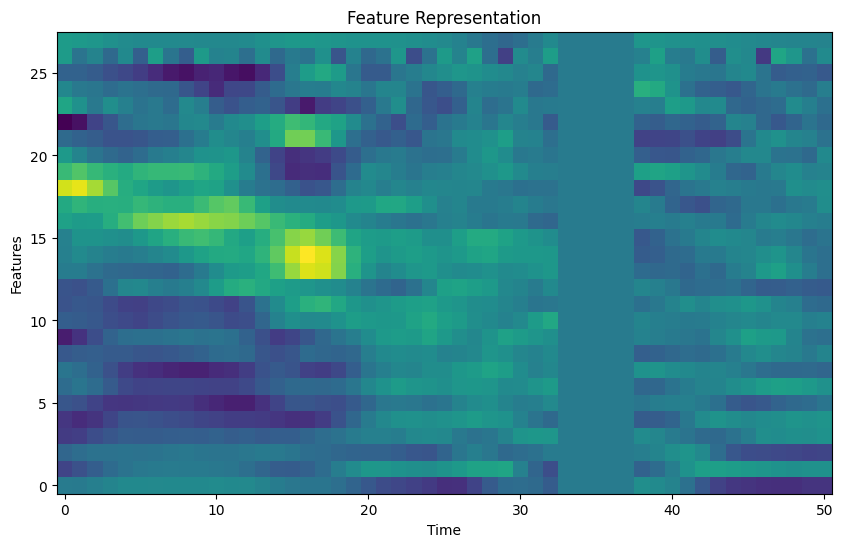

In [ ]:
import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [ ]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [ ]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, input_size, output_size, config=None):
        super(Network, self).__init__()
        self.config = config if config is not None else {}

        self.model = nn.Sequential(
            # First hidden layer: 2048 neurons
            nn.Linear(input_size, 2048),
            nn.GELU(),  # Activation function
            nn.BatchNorm1d(2048),  # Normalize activations
            nn.Dropout(p=0.25),  # Dropout for regularization

            # Second hidden layer: 2048 neurons
            nn.Linear(2048, 2048),
            nn.GELU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),

            # Third hidden layer: 2048 neurons
            nn.Linear(2048, 2048),
            nn.GELU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),

            # Fourth hidden layer: 1024 neurons
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),

            # Fifth hidden layer: 2048 neurons
            nn.Linear(1024, 2048),
            nn.GELU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),

            # Sixth hidden layer: 1024 neurons
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),

            # Seventh hidden layer: 1024 neurons
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),

            # Eighth hidden layer: 768 neurons
            nn.Linear(1024, 768),
            nn.GELU(),
            nn.BatchNorm1d(768),
            nn.Dropout(p=0.25),

            # Ninth hidden layer: 512 neurons
            nn.Linear(768, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.25),

            # Tenth hidden layer: 128 neurons
            nn.Linear(512, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.25),

            # Output layer
            nn.Linear(128, output_size)  # No activation function
        )


        # Apply weight initialization if specified
        if self.config.get('weight_initialization'):
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init_type = self.config.get("weight_initialization")
                if init_type == "xavier_normal":
                    nn.init.xavier_normal_(m.weight)
                elif init_type == "xavier_uniform":
                    nn.init.xavier_uniform_(m.weight)
                elif init_type == "kaiming_normal":
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif init_type == "kaiming_uniform":
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif init_type == "uniform":
                    nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")

                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Keeps batch size, flattens the rest
        return self.model(x)


# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [ ]:
INPUT_SIZE  = (2*config['context'] + 1) * 28
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device).cuda()
summary(model, input_size=[(2*config['context']+1, 28)], device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       2,926,592
              GELU-2                 [-1, 2048]               0
       BatchNorm1d-3                 [-1, 2048]           4,096
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 2048]       4,196,352
              GELU-6                 [-1, 2048]               0
       BatchNorm1d-7                 [-1, 2048]           4,096
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 2048]       4,196,352
             GELU-10                 [-1, 2048]               0
      BatchNorm1d-11                 [-1, 2048]           4,096
          Dropout-12                 [-1, 2048]               0
           Linear-13                 [-1, 1024]       2,098,176
             GELU-14                 [-

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

# Choose an appropriate optimizer of your choice
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['min_lr'])


scaler = torch.amp.GradScaler('cuda', enabled=True)

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [ ]:
# CLEAR RAM!!
torch.cuda.empty_cache()
gc.collect()

1006

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [ ]:
wandb.login(key="6000248c014f1c7f1252913b5c6b754aa8211d49") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "first-run1", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

In [ ]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20250210_131325-80xpg7ap/files/model_arch.txt']

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [ ]:
import torch
import gc

# Initialize best validation accuracy
best_val_acc = 0.0

torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ## Log metrics at each epoch in your run
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    # Step the learning rate scheduler if applicable
    scheduler.step()

    ## Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = "best_model.pth"
        torch.save({'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc},
                   best_model_path)
        print(f"Best model saved with val_acc: {val_acc*100:.04f}% at {best_model_path}")



Epoch 1/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 70.1652%	Train Loss 0.9685	 Learning Rate 0.0005000
	Val Acc 78.5445%	Val Loss 0.6520
✅ Best model saved with val_acc: 78.5445% at best_model.pth

Epoch 2/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 75.8278%	Train Loss 0.7645	 Learning Rate 0.0004994
	Val Acc 80.6494%	Val Loss 0.5834
✅ Best model saved with val_acc: 80.6494% at best_model.pth

Epoch 3/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 77.3775%	Train Loss 0.7098	 Learning Rate 0.0004976
	Val Acc 81.7533%	Val Loss 0.5451
✅ Best model saved with val_acc: 81.7533% at best_model.pth

Epoch 4/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 78.2151%	Train Loss 0.6808	 Learning Rate 0.0004945
	Val Acc 82.1402%	Val Loss 0.5331
✅ Best model saved with val_acc: 82.1402% at best_model.pth

Epoch 5/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 78.8249%	Train Loss 0.6595	 Learning Rate 0.0004903
	Val Acc 82.6402%	Val Loss 0.5165
✅ Best model saved with val_acc: 82.6402% at best_model.pth

Epoch 6/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 79.2636%	Train Loss 0.6444	 Learning Rate 0.0004849
	Val Acc 82.8642%	Val Loss 0.5096
✅ Best model saved with val_acc: 82.8642% at best_model.pth

Epoch 7/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 79.5763%	Train Loss 0.6332	 Learning Rate 0.0004784
	Val Acc 83.2878%	Val Loss 0.4957
✅ Best model saved with val_acc: 83.2878% at best_model.pth

Epoch 8/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 79.9054%	Train Loss 0.6218	 Learning Rate 0.0004707
	Val Acc 83.6374%	Val Loss 0.4853
✅ Best model saved with val_acc: 83.6374% at best_model.pth

Epoch 9/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 80.1917%	Train Loss 0.6114	 Learning Rate 0.0004620
	Val Acc 83.7967%	Val Loss 0.4808
✅ Best model saved with val_acc: 83.7967% at best_model.pth

Epoch 10/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 80.4378%	Train Loss 0.6030	 Learning Rate 0.0004523
	Val Acc 83.8459%	Val Loss 0.4778
✅ Best model saved with val_acc: 83.8459% at best_model.pth

Epoch 11/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 80.7879%	Train Loss 0.5909	 Learning Rate 0.0004415
	Val Acc 84.2021%	Val Loss 0.4665
✅ Best model saved with val_acc: 84.2021% at best_model.pth

Epoch 12/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.0615%	Train Loss 0.5813	 Learning Rate 0.0004298
	Val Acc 84.3001%	Val Loss 0.4637
✅ Best model saved with val_acc: 84.3001% at best_model.pth

Epoch 13/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.3043%	Train Loss 0.5728	 Learning Rate 0.0004173
	Val Acc 84.4625%	Val Loss 0.4583
✅ Best model saved with val_acc: 84.4625% at best_model.pth

Epoch 14/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.5047%	Train Loss 0.5658	 Learning Rate 0.0004039
	Val Acc 84.5400%	Val Loss 0.4556
✅ Best model saved with val_acc: 84.5400% at best_model.pth

Epoch 15/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.6815%	Train Loss 0.5596	 Learning Rate 0.0003898
	Val Acc 84.7856%	Val Loss 0.4483
✅ Best model saved with val_acc: 84.7856% at best_model.pth

Epoch 16/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.8914%	Train Loss 0.5520	 Learning Rate 0.0003750
	Val Acc 84.9303%	Val Loss 0.4437
✅ Best model saved with val_acc: 84.9303% at best_model.pth

Epoch 17/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 81.9881%	Train Loss 0.5486	 Learning Rate 0.0003596
	Val Acc 84.9329%	Val Loss 0.4431
✅ Best model saved with val_acc: 84.9329% at best_model.pth

Epoch 18/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.1465%	Train Loss 0.5430	 Learning Rate 0.0003437
	Val Acc 84.8791%	Val Loss 0.4446

Epoch 19/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.2834%	Train Loss 0.5381	 Learning Rate 0.0003273
	Val Acc 85.0816%	Val Loss 0.4386
✅ Best model saved with val_acc: 85.0816% at best_model.pth

Epoch 20/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.4494%	Train Loss 0.5324	 Learning Rate 0.0003105
	Val Acc 84.9538%	Val Loss 0.4437

Epoch 21/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.5621%	Train Loss 0.5285	 Learning Rate 0.0002934
	Val Acc 85.1096%	Val Loss 0.4374
✅ Best model saved with val_acc: 85.1096% at best_model.pth

Epoch 22/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.7231%	Train Loss 0.5226	 Learning Rate 0.0002761
	Val Acc 85.4505%	Val Loss 0.4273
✅ Best model saved with val_acc: 85.4505% at best_model.pth

Epoch 23/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.8468%	Train Loss 0.5181	 Learning Rate 0.0002587
	Val Acc 85.5175%	Val Loss 0.4246
✅ Best model saved with val_acc: 85.5175% at best_model.pth

Epoch 24/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 82.9939%	Train Loss 0.5130	 Learning Rate 0.0002413
	Val Acc 85.5964%	Val Loss 0.4228
✅ Best model saved with val_acc: 85.5964% at best_model.pth

Epoch 25/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.1579%	Train Loss 0.5072	 Learning Rate 0.0002239
	Val Acc 85.4280%	Val Loss 0.4276

Epoch 26/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.3086%	Train Loss 0.5019	 Learning Rate 0.0002066
	Val Acc 85.7941%	Val Loss 0.4174
✅ Best model saved with val_acc: 85.7941% at best_model.pth

Epoch 27/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.4626%	Train Loss 0.4965	 Learning Rate 0.0001895
	Val Acc 85.7476%	Val Loss 0.4177

Epoch 28/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.6085%	Train Loss 0.4916	 Learning Rate 0.0001727
	Val Acc 85.9323%	Val Loss 0.4110
✅ Best model saved with val_acc: 85.9323% at best_model.pth

Epoch 29/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.7752%	Train Loss 0.4859	 Learning Rate 0.0001563
	Val Acc 86.0116%	Val Loss 0.4108
✅ Best model saved with val_acc: 86.0116% at best_model.pth

Epoch 30/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 83.8896%	Train Loss 0.4814	 Learning Rate 0.0001404
	Val Acc 85.8089%	Val Loss 0.4176

Epoch 31/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.0450%	Train Loss 0.4760	 Learning Rate 0.0001250
	Val Acc 86.1022%	Val Loss 0.4069
✅ Best model saved with val_acc: 86.1022% at best_model.pth

Epoch 32/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.2059%	Train Loss 0.4706	 Learning Rate 0.0001102
	Val Acc 86.1939%	Val Loss 0.4044
✅ Best model saved with val_acc: 86.1939% at best_model.pth

Epoch 33/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.3313%	Train Loss 0.4660	 Learning Rate 0.0000961
	Val Acc 86.1807%	Val Loss 0.4056

Epoch 34/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.4777%	Train Loss 0.4609	 Learning Rate 0.0000827
	Val Acc 86.4087%	Val Loss 0.3976
✅ Best model saved with val_acc: 86.4087% at best_model.pth

Epoch 35/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.6062%	Train Loss 0.4562	 Learning Rate 0.0000702
	Val Acc 86.2686%	Val Loss 0.4038

Epoch 36/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.7455%	Train Loss 0.4516	 Learning Rate 0.0000585
	Val Acc 86.3380%	Val Loss 0.4000

Epoch 37/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.8464%	Train Loss 0.4479	 Learning Rate 0.0000477
	Val Acc 86.5175%	Val Loss 0.3959
✅ Best model saved with val_acc: 86.5175% at best_model.pth

Epoch 38/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

Val:   0%|          | 0/1884 [00:00<?, ?it/s]

	Train Acc 84.9683%	Train Loss 0.4441	 Learning Rate 0.0000380
	Val Acc 86.6603%	Val Loss 0.3920
✅ Best model saved with val_acc: 86.6603% at best_model.pth

Epoch 39/45


Train:   0%|          | 0/35246 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [ ]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.no_grad(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim=1)

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # Remember the phonemes were converted to their corresponding integer indices earlier, and the results of the argmax is a list of the indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes
            # TODO: Store predicted_phonemes
            test_predictions.extend(predicted_phonemes.cpu().numpy())

    return test_predictions

In [ ]:
predictions = test(model, test_loader)

  0%|          | 0/1889 [00:00<?, ?it/s]

In [ ]:
x = [PHONEMES[0:-2][prediction] for prediction in predictions]

In [ ]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(x)):
        f.write("{},{}\n".format(i, x[i]))

In [ ]:
### Finish your wandb run
run.finish()

lr,████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
train_acc,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇████████
valid_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
lr,4e-05
train_acc,84.96829
train_loss,0.44405
val_acc,86.6603
valid_loss,0.39196


In [ ]:
import os

# Define the directory path
save_dir = "/Users/vishakhapathak/Desktop"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Define the full file path
file_path = os.path.join(save_dir, "submission.csv")

# Create and save the CSV file
with open(file_path, "w+") as f:
    f.write("id,label\n")
    for i in range(len(x)):
        f.write("{},{}\n".format(i, x[i]))

print(f"CSV file saved at: {file_path}")


CSV file saved at: /Users/vishakhapathak/Desktop/submission.csv
